**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import ExtraTreeClassifier
from sklearn.impute import SimpleImputer
import copy
import warnings
warnings.simplefilter('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import statistics


In [243]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [244]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [245]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [246]:
TRAIN_DATASET_PATH ='../input/course_project_train.csv'
TEST_DATASET_PATH ='../input/course_project_test.csv'
PREP_DATASET_PATH = '../training_project_data_prep.csv'
SCALER_FILE_PATH = '../scaler.pkl'


In [247]:
TARGET_NAME = 'Credit Default'

###   Загрузка данных

In [248]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [249]:
df_train.shape

(7500, 17)

In [250]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [251]:
df_train.dtypes.value_counts()

float64    12
object      4
int64       1
dtype: int64

In [252]:
numeric_f = df_train.select_dtypes('number').columns.drop(TARGET_NAME)
numeric_f

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score'],
      dtype='object')

In [253]:
categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()
categorical_features

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [254]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [255]:
df_test.shape

(2500, 16)

In [256]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [257]:
df_train.dtypes.value_counts()

float64    12
object      4
int64       1
dtype: int64

## Обзор данных

### Обзор целевой переменной

In [258]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

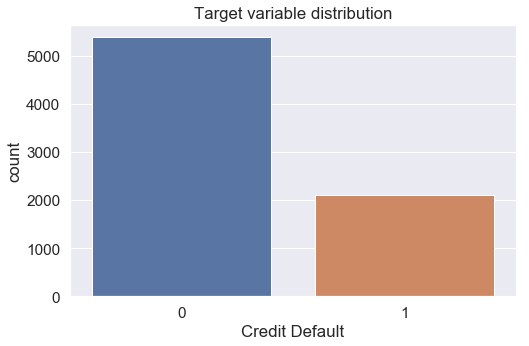

In [259]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

### Обзор количественных признаков

In [260]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [261]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [262]:
def plot_outliers(df_train, df_test, col_name, hist = False):
    fig, ax = plt.subplots(1,3,figsize=(16,5))
    #ax[0].set_title(f'KDE for both datasets on {col_name}')
    ax[1].set_title('Train Dataset')
    ax[2].set_title('Test Dataset')
    sns.distplot(df_train[col_name], color='b', ax=ax[0], hist=hist, label='Train')
    sns.distplot(df_test[col_name], color='r', ax=ax[0], hist=hist, label='Test')
    sns.boxplot(df_train[col_name], ax=ax[1])
    sns.boxplot(df_test[col_name], color='r', ax=ax[2])
    plt.show()

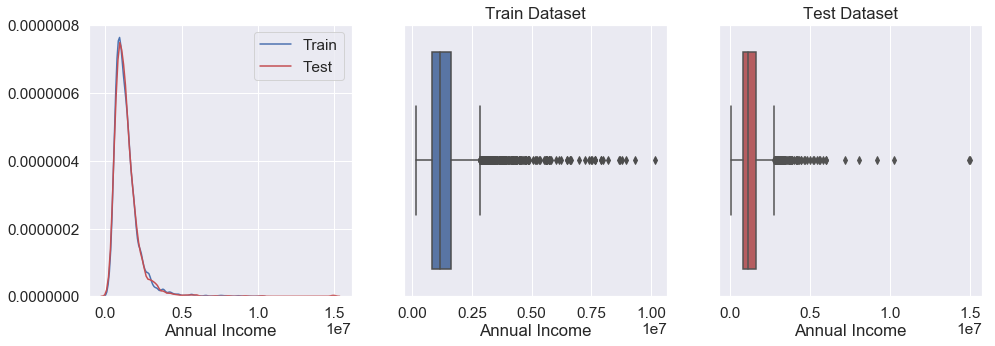

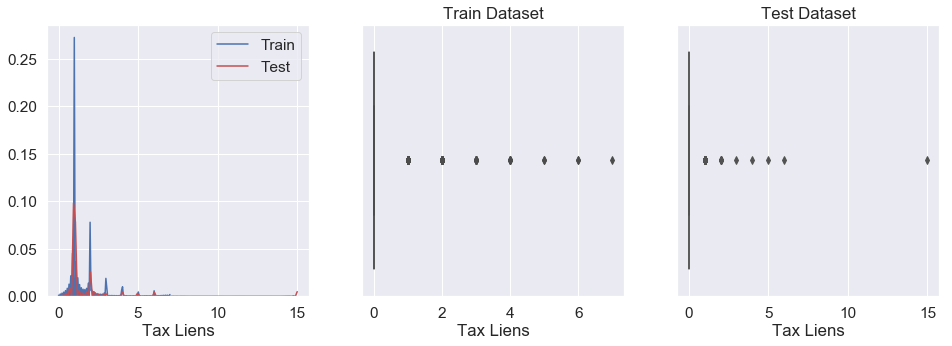

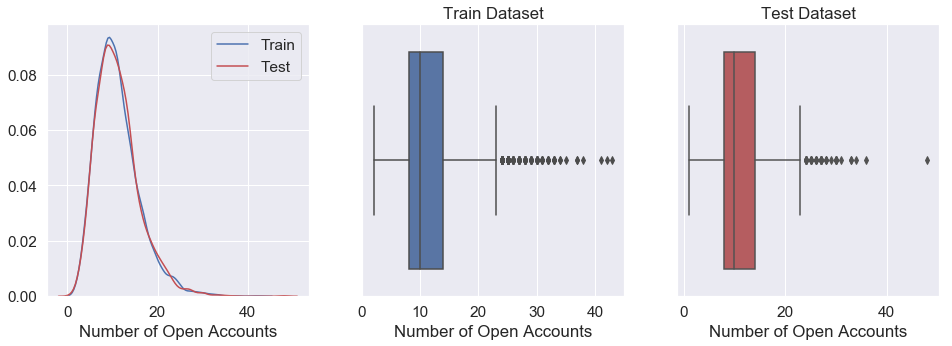

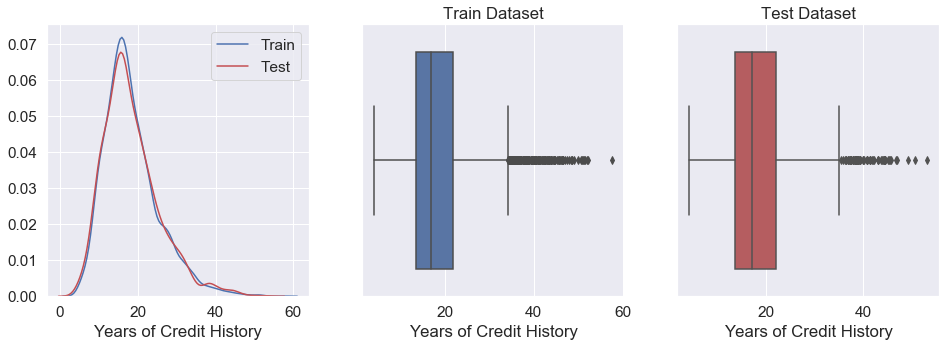

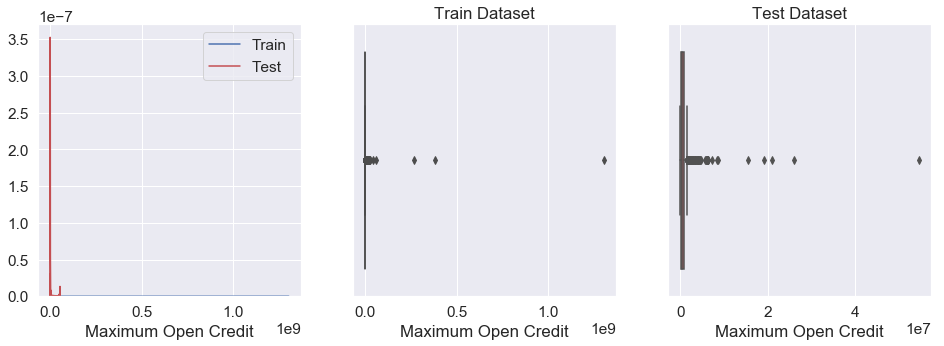

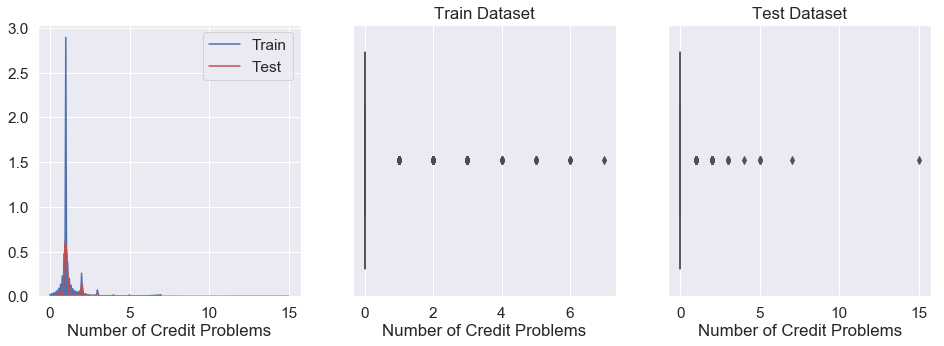

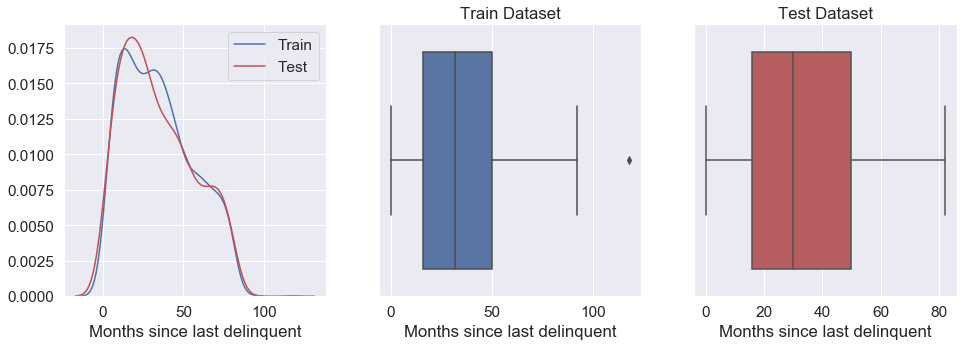

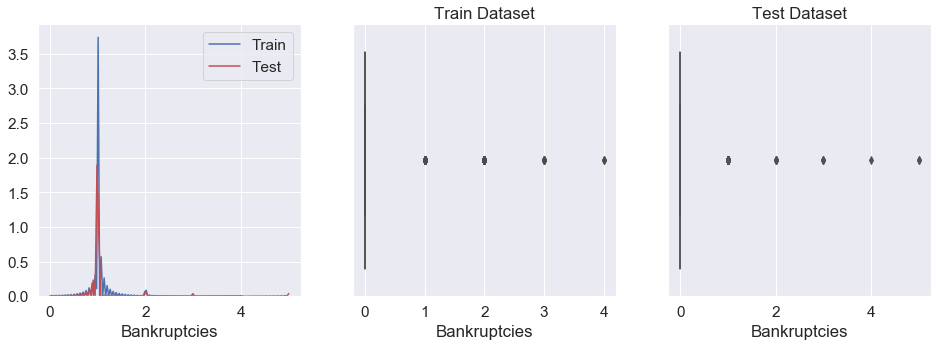

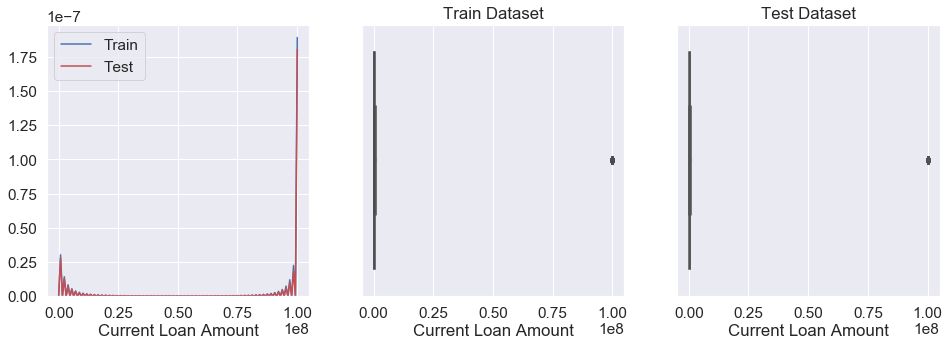

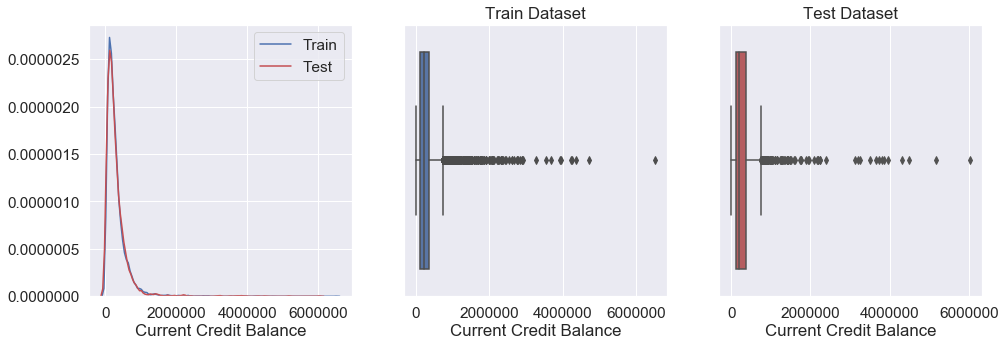

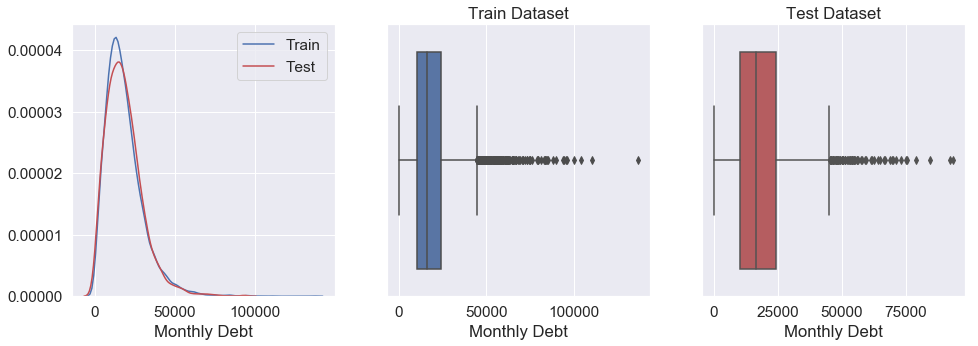

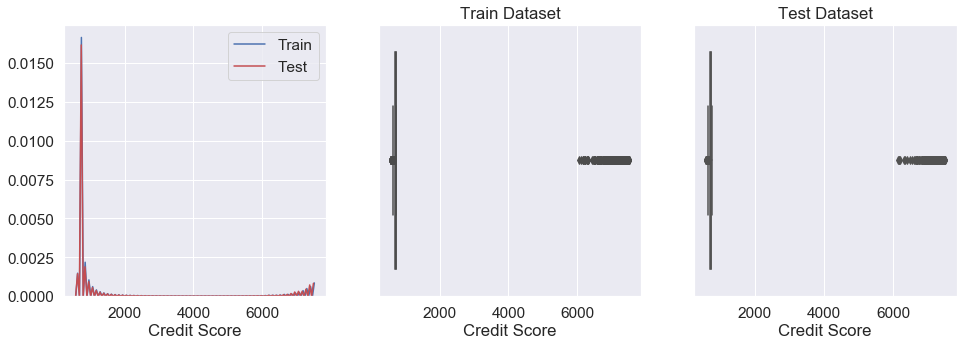

In [263]:
for col in numeric_f:
    plot_outliers(df_train, df_test,col)

Среди количественных признаков 'Tax Liens','Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies'  есть расхождения в распределении для тестовой и тренировочной частей. Удалим эти данные.

In [264]:
del_list = ['Tax Liens','Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies']

df_train.drop(del_list,axis=1,inplace=True)
df_test.drop(del_list,axis=1,inplace=True)

### Обзор номинативных признаков

In [265]:
categorical_features 

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

### train

In [266]:
for cat_colname in df_train.select_dtypes(include=['object']).columns.tolist():
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### test

In [267]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

### Years in current job

In [268]:
moda_yinCJ=statistics.mode(df_train['Years in current job'])
df_train.loc[df_train['Years in current job'].isna(),'Years in current job']=moda_yinCJ[0]
df_test.loc[df_test['Years in current job'].isna(),'Years in current job']=moda_yinCJ[0]

In [269]:
df_train['Years in current job'] = df_train['Years in current job'].apply(lambda x: str(x).replace('1','1 year').replace('1 year0+ years','0+ year').replace('1 year year','1 year').replace('< 1 year year','0+ year').replace('< 1 year','0+ year'))
df_test['Years in current job'] = df_test['Years in current job'].apply(lambda x: str(x).replace('1','1 year').replace('1 year0+ years','0+ year').replace('1 year year','1 year').replace('< 1 year year','0+ year').replace('< 1 year','0+ year'))

In [270]:
df_train['Years in current job'].unique()

array(['1 year', '0+ year', '8 years', '6 years', '7 years', '5 years',
       '4 years', '3 years', '2 years', '9 years'], dtype=object)

In [271]:
df_test['Years in current job'].unique()

array(['4 years', '1 year', '3 years', '0+ year', '6 years', '5 years',
       '2 years', '9 years', '8 years', '7 years'], dtype=object)

In [272]:
df_train['YinCJ'] = df_train['Years in current job'].apply(lambda x: str(x).replace('years','').replace('year','').replace('+','')).astype('float')
df_test['YinCJ'] = df_test['Years in current job'].apply(lambda x: str(x).replace('years','').replace('year','').replace('+','')).astype('float')

In [273]:
df_train['YinCJ'].unique()


array([1., 0., 8., 6., 7., 5., 4., 3., 2., 9.])

In [274]:
df_test['YinCJ'].unique()

array([4., 1., 3., 0., 6., 5., 2., 9., 8., 7.])

### Home Ownership

In [275]:
df_train = df_train.replace(['Have Mortgage'],['Home Mortgage'])

In [276]:
df_test = df_test.replace(['Have Mortgage'],['Home Mortgage'])

### Purpose

In [277]:
df_train['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

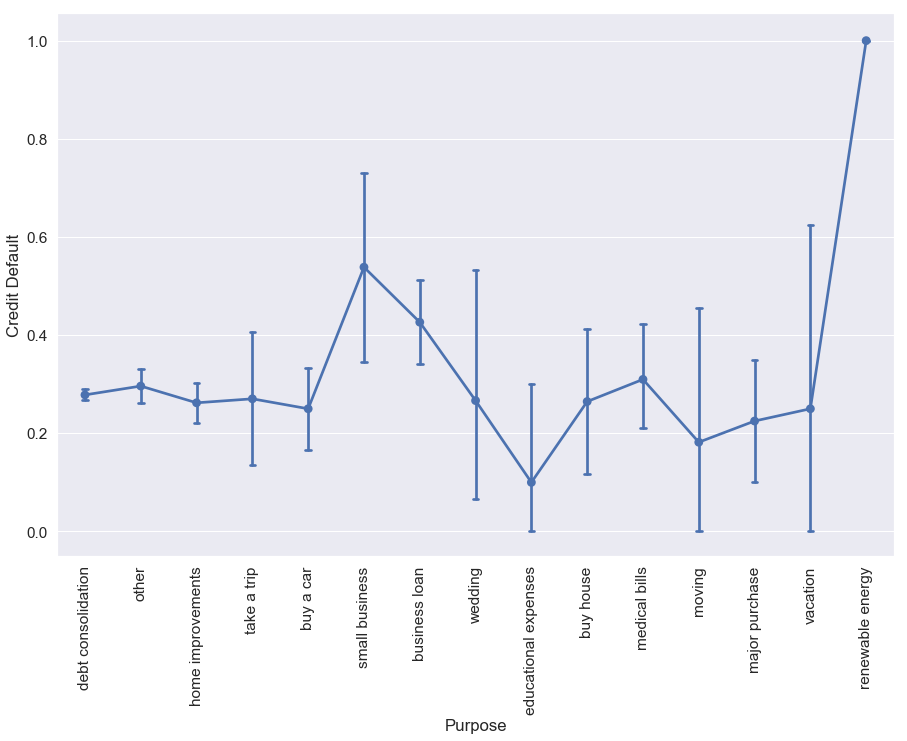

In [278]:
plt.figure(figsize=(15, 10))

sns.pointplot(x='Purpose', y='Credit Default', data=df_train, capsize=.1,)

plt.xticks( rotation='vertical') 

In [279]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [280]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

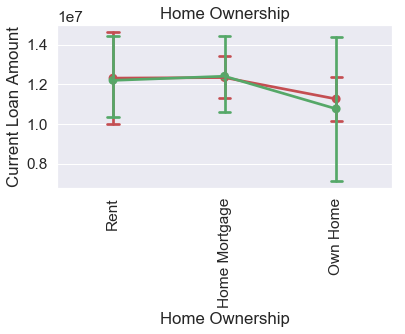

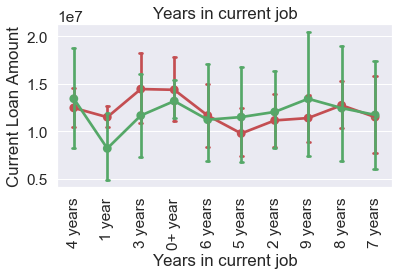

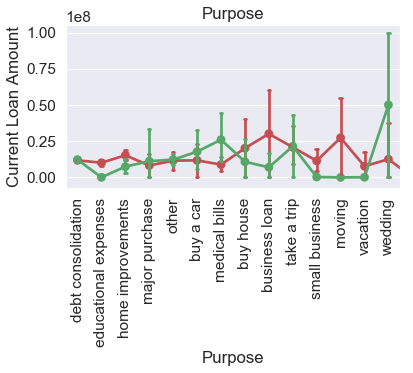

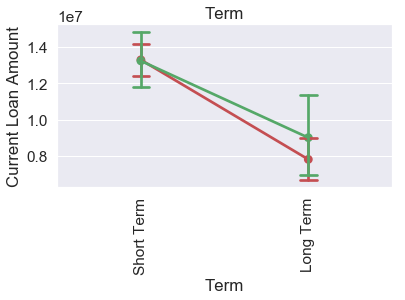

In [281]:
for col in categorical_features:
    plt.figure(figsize=(6, 3))
    sns.pointplot(x=col, y='Current Loan Amount', data=df_train, capsize=.1,label='train', color='r')
    sns.pointplot(x=col, y='Current Loan Amount', data=df_test, capsize=.1,label='test', color='g')
    plt.title(col)
    plt.xticks( rotation='vertical') 
    plt.show()

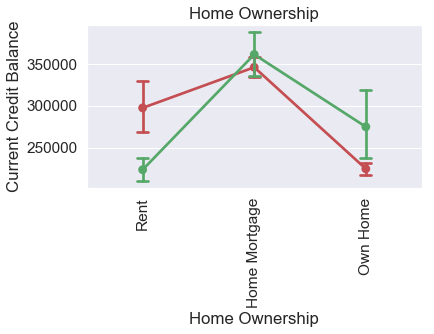

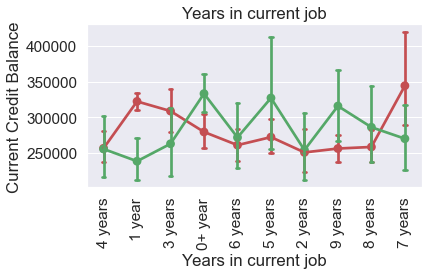

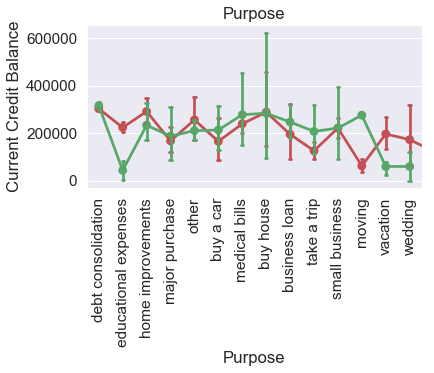

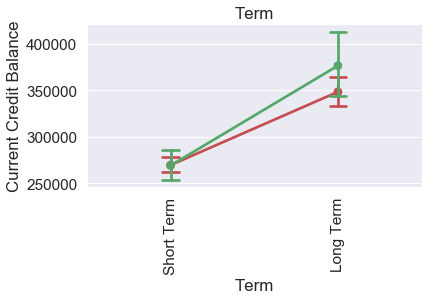

In [282]:
for col in categorical_features:
    plt.figure(figsize=(6, 3))
    sns.pointplot(x=col, y='Current Credit Balance', data=df_train, capsize=.1,label='train', color='r')
    sns.pointplot(x=col, y='Current Credit Balance', data=df_test, capsize=.1,label='test', color='g')
    plt.title(col)
    plt.xticks( rotation='vertical') 
    plt.show()

Удалим признак 'Years in current job'

In [283]:
del_list = ['Years in current job']

df_train.drop(del_list,axis=1,inplace=True)
df_test.drop(del_list,axis=1,inplace=True)

In [284]:
categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()
categorical_features

['Home Ownership', 'Purpose', 'Term']

**Корреляция с базовыми признаками**

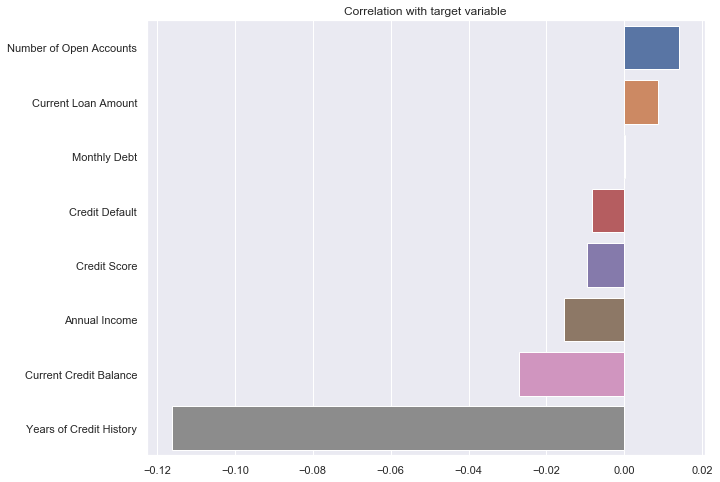

In [285]:
df = df_train.copy()
df_t = df_test.copy()

corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)
sns.set(font_scale=1)
plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

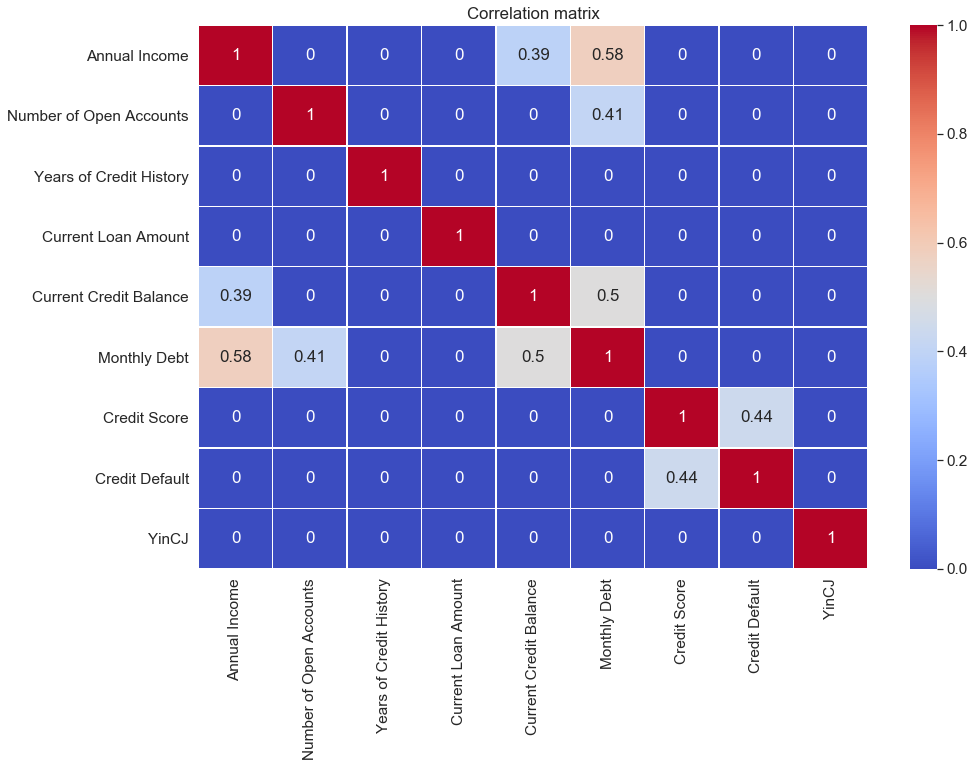

In [286]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()


### Обработка выбросов

In [287]:
def current_loan_amount(df):
    df.loc[df['Current Loan Amount']==99999999.0,'Current Loan Amount'] = df['Current Loan Amount'].median()
    return df

In [288]:
def credit_score(df):
    df.loc[df['Credit Score']>850,'Credit Score']=df.loc[df['Credit Score']>850,'Credit Score']/10
    return df

In [289]:
df_train = credit_score(df_train)
df_test = credit_score(df_test)

In [290]:
df_train = current_loan_amount(df_train)
df_test = current_loan_amount(df_test)

In [ ]:
test_df[test_df['Floor'] > test_df['HouseFloor']]

In [291]:
df_train.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,YinCJ
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,5943.000000,7500.000000,7500.000000
mean,1.366392e+06,11.130933,18.317467,309088.029067,2.898332e+05,18314.454133,720.086993,0.281733,2.529600
std,8.453392e+05,4.908924,7.041946,171393.740131,3.178714e+05,11926.764673,27.957233,0.449874,2.807379
min,1.645970e+05,2.000000,4.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000,0.000000
25%,8.443410e+05,8.000000,13.500000,180169.000000,1.142565e+05,10067.500000,708.000000,0.000000,0.000000
50%,1.168386e+06,10.000000,17.000000,309567.500000,2.093230e+05,16076.500000,729.000000,0.000000,1.000000
75%,1.640137e+06,14.000000,21.800000,396929.500000,3.604062e+05,23818.000000,740.000000,1.000000,5.000000
max,1.014934e+07,43.000000,57.700000,789030.000000,6.506797e+06,136679.000000,751.000000,1.000000,9.000000


In [292]:
df_test.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,YinCJ
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1987.000000,2500.000000
mean,1.366922e+06,11.184400,18.325920,314016.832800,2.963966e+05,18271.340000,719.542023,2.539600
std,9.171252e+05,4.852774,7.254659,171498.178859,3.783020e+05,11543.881469,27.724287,2.852312
min,1.065330e+05,1.000000,3.900000,15422.000000,0.000000e+00,93.000000,585.000000,0.000000
25%,8.523115e+05,8.000000,13.400000,187126.500000,1.101145e+05,10024.750000,706.000000,0.000000
50%,1.178475e+06,10.000000,17.000000,322355.000000,2.073850e+05,16642.500000,727.000000,1.000000
75%,1.629734e+06,14.000000,22.100000,398893.000000,3.663485e+05,24146.000000,740.000000,5.000000
max,1.497561e+07,48.000000,53.400000,789096.000000,6.030087e+06,93555.000000,751.000000,9.000000


### Обработка пропусков

In [293]:
numeric_f

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score'],
      dtype='object')

#### Annual Income

In [294]:
def my_rfr(input_train, input_valid, input_need_predict, target_col, scale):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import r2_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.preprocessing import StandardScaler
    #Создаю копии полученных данных
    train = copy.deepcopy(input_train)
    valid = copy.deepcopy(input_valid)
    need_predict = copy.deepcopy(input_need_predict)
    if (scale):
        print("Масштабирую данные")
        scaler = StandardScaler()
        train_scaler = scaler.fit_transform(train)
        train = pd.DataFrame(train_scaler, columns=train.columns)
        valid_scaler = scaler.fit_transform(valid)
        valid = pd.DataFrame(valid_scaler, columns=valid.columns)
        
    
    #Создаю регрессионную модель
    model = RandomForestRegressor(n_estimators=1000, max_depth=120, max_features=input_train.shape[1]-1, n_jobs=-1, random_state=42, verbose=1)
    train_target = train.pop(target_col) #Отделяю целевое значение
    model.fit(train, train_target) #Обучаю модель
    pred_train = model.predict(train)
    print(f"r2 на учебной выборке: {r2_score(train_target, pred_train)}")
    if (type(valid) != bool):
        print(f"Произвожу валидацию")
        valid_target = valid.pop(target_col)
        pred_valid = model.predict(valid)
        print(f"r2 на валидационной выборке: {r2_score(valid_target, pred_valid)}")

    
    if (type(need_predict) != bool):
        print(f"Прогнозирую {target_col}")
        need_predict.pop(target_col)
        print(need_predict.shape)
        return model

In [295]:
HOME_OWNERSHIP = "Home Ownership"
ANNUAL_INCOME = "Annual Income"
YEARS_OF_CREDIT_HISTORY = "Years of Credit History"
PURPOSE = "Purpose"
TERM = "Term"
CURRENT_LOAN_AMOUNT = "Current Loan Amount"
CURRENT_CREDIT_BALANCE = "Current Credit Balance"
MONTHLY_DEBT = "Monthly Debt"
CREDIT_SCORE = "Credit Score"
CREDIT_DEFAULT = "Credit Default"

In [296]:
df_temp =df_train[['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
        'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt']].copy()
df_temp_test = df_test[['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
        'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt']].copy()



#отделяю значения которые надо прогнозировать
annual_income_predict = df_temp.loc[df_temp[ANNUAL_INCOME].isnull()] 
annual_income_predict_test = df_temp_test.loc[df_temp_test[ANNUAL_INCOME].isnull()] 

#отделяю значения которые буду использовать при обучении
annual_income_train = df_temp.loc[df_temp[ANNUAL_INCOME] > 0] 

annual_income_predictor = my_rfr(annual_income_train, False, annual_income_predict, ANNUAL_INCOME, False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   14.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.3s finished


r2 на учебной выборке: 0.9138162078909244
Прогнозирую Annual Income
(1557, 5)


In [297]:
a_predict=annual_income_predictor.predict(annual_income_predict.iloc[:,1:])
a_predict_test=annual_income_predictor.predict(annual_income_predict_test.iloc[:,1:])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [298]:
df_train.loc[df_temp[ANNUAL_INCOME].isnull(), ANNUAL_INCOME] = a_predict
df_test.loc[df_temp_test[ANNUAL_INCOME].isnull(), ANNUAL_INCOME] = a_predict_test

#### нормализация

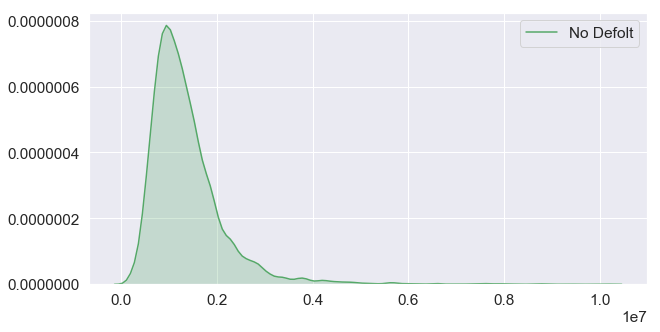

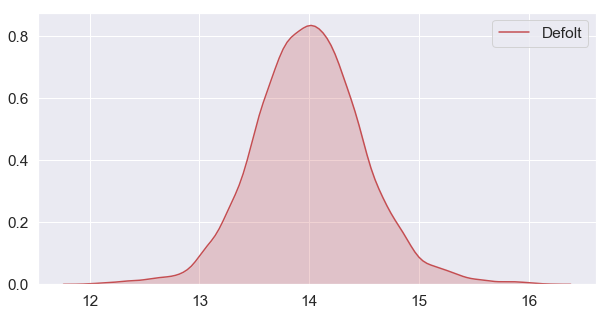

In [299]:
plt.figure(figsize=(10, 5))

sns.kdeplot(df_train['Annual Income'], shade=True, label='No Defolt', color='g')

plt.show()
plt.figure(figsize=(10, 5))

sns.kdeplot(np.log(df_train['Annual Income']), shade=True, label='Defolt', color='r')

plt.show()

In [300]:
df_train['Annual Income']=np.log(df_train['Annual Income'])
df_test['Annual Income']=np.log(df_test['Annual Income'])

#### Credit Score

In [301]:
df_temp =df_train[['Credit Score', 'Number of Open Accounts', 'Years of Credit History',
        'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt']].copy()
df_temp_test = df_test[['Credit Score', 'Number of Open Accounts', 'Years of Credit History',
        'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt']].copy()



#отделяю значения которые надо прогнозировать
credit_score_predict = df_temp.loc[df_temp[CREDIT_SCORE].isnull()] 
credit_score_predict_test = df_temp_test.loc[df_temp_test[CREDIT_SCORE].isnull()] 

#отделяю значения которые буду использовать при обучении
credit_score_train = df_temp.loc[df_temp[CREDIT_SCORE] > 0] 

credit_score_predictor = my_rfr(credit_score_train, False, credit_score_predict, CREDIT_SCORE, False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.7s finished


r2 на учебной выборке: 0.8668855268503264
Прогнозирую Credit Score
(1557, 5)


In [302]:
df_train.loc[df_temp[CREDIT_SCORE].isnull(), CREDIT_SCORE] = a_predict
df_test.loc[df_temp_test[CREDIT_SCORE].isnull(), CREDIT_SCORE] = a_predict_test

#### нормализация

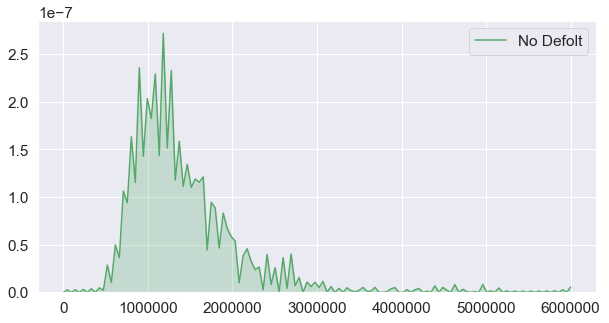

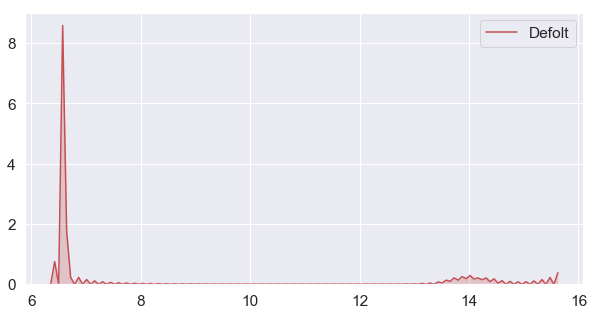

In [303]:
plt.figure(figsize=(10, 5))

sns.kdeplot(df_train['Credit Score'], shade=True, label='No Defolt', color='g')

plt.show()
plt.figure(figsize=(10, 5))

sns.kdeplot(np.log(df_train['Credit Score']), shade=True, label='Defolt', color='r')

plt.show()

In [304]:
df_train['Credit Score']=np.log(df_train['Credit Score'])
df_test['Credit Score']=np.log(df_test['Credit Score'])

### Объединение признаков

#### Purpose

In [305]:
df_train['ID'] = df_train.index
df_test['ID'] = df_test.index

In [306]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

In [307]:
def CHi_check(df=df_train,col=None,list_samp =None):
    p=0
    numb_sample = np.sum(df[col].isin(list_samp))
    #print(numb_sample)
    if numb_sample>500:
        numb_sample=500
        if numb_sample>50:
            pay1_and_target_s = df.loc[df[col].isin(list_samp), ['ID', col, 'Credit Default']].sample(500)
            table = pay1_and_target_s.pivot_table(values='ID', index=col, columns='Credit Default', aggfunc='count')
            #print(table)
            chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return p

In [308]:
alph = 0.05
for col in categorical_features:
    f_uniq = df_train[col].unique()
    #print(col,': ',f_uniq)
    for i in f_uniq:
        for j in f_uniq:
            
            p = CHi_check(df=df_train,col=col,list_samp =[i,j])
            
            if p> alph:
                print(col,': [',i,',',j,']  -',p>alph)

Home Ownership : [ Own Home , Own Home ]  - True
Home Ownership : [ Own Home , Home Mortgage ]  - True
Home Ownership : [ Own Home , Rent ]  - True
Home Ownership : [ Home Mortgage , Own Home ]  - True
Home Ownership : [ Home Mortgage , Home Mortgage ]  - True
Home Ownership : [ Home Mortgage , Rent ]  - True
Home Ownership : [ Rent , Own Home ]  - True
Home Ownership : [ Rent , Home Mortgage ]  - True
Home Ownership : [ Rent , Rent ]  - True
Purpose : [ debt consolidation , debt consolidation ]  - True
Purpose : [ debt consolidation , other ]  - True
Purpose : [ debt consolidation , home improvements ]  - True
Purpose : [ debt consolidation , buy a car ]  - True
Purpose : [ debt consolidation , small business ]  - True
Purpose : [ debt consolidation , wedding ]  - True
Purpose : [ debt consolidation , buy house ]  - True
Purpose : [ debt consolidation , medical bills ]  - True
Purpose : [ debt consolidation , moving ]  - True
Purpose : [ debt consolidation , major purchase ]  - True
P

In [309]:
def purpose_change(df):
    df.loc[df['Purpose'].isin(['debt consolidation','business loan','renewable energy']),'Purpose']='debt consolidation'
    df.loc[df['Purpose'].isin(['other','home improvements','buy a car','medical bills','buy house','take a trip','major purchase','educational expenses','wedding','moving']),'Purpose']='other'
    #print(df.head())
    return df
df_test=purpose_change(df_test)
df_train=purpose_change(df_train)

In [310]:
df_train['Purpose'].value_counts()

debt consolidation    6075
other                 1391
small business          26
vacation                 8
Name: Purpose, dtype: int64

In [311]:
df_test['Purpose'].value_counts()

debt consolidation    2003
other                  489
small business           5
vacation                 3
Name: Purpose, dtype: int64

### Создание новых признаков

In [312]:
def preprocess_feature(df, col):
    return pd.get_dummies(df, prefix=[col[0:3]], columns=[col])

In [313]:
df_train_new = preprocess_feature(df_train,HOME_OWNERSHIP)
df_test_new= preprocess_feature(df_test,HOME_OWNERSHIP)

In [314]:
df_train_new = preprocess_feature(df_train_new,PURPOSE)
df_test_new = preprocess_feature(df_test_new,PURPOSE)

In [315]:
df_train_new = preprocess_feature(df_train_new,TERM)
df_test_new = preprocess_feature(df_test_new,TERM)

In [316]:
df_train_new.head()

,Annual Income,Number of Open Accounts,Years of Credit History,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,YinCJ,ID,Hom_Home Mortgage,Hom_Own Home,Hom_Rent,Pur_debt consolidation,Pur_other,Pur_small business,Pur_vacation,Ter_Long Term,Ter_Short Term
0,13.085880,11.0,26.3,309573.0,47386.0,7914.0,6.618739,0,1.0,0,0,1,0,1,0,0,0,0,1
1,13.840678,15.0,15.3,264968.0,394972.0,18373.0,6.602588,1,0.0,1,0,1,0,1,0,0,0,1,0
2,13.529709,11.0,35.0,309573.0,308389.0,13651.0,6.609349,0,8.0,2,1,0,0,1,0,0,0,0,1
3,13.598682,8.0,22.5,121396.0,95855.0,11338.0,6.542472,0,6.0,3,0,1,0,1,0,0,0,0,1
4,13.562248,13.0,13.6,125840.0,93309.0,7180.0,6.577861,0,8.0,4,0,0,1,1,0,0,0,0,1


In [317]:
df_test_new.head()

,Annual Income,Number of Open Accounts,Years of Credit History,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,YinCJ,ID,Hom_Home Mortgage,Hom_Own Home,Hom_Rent,Pur_debt consolidation,Pur_other,Pur_small business,Pur_vacation,Ter_Long Term,Ter_Short Term
0,13.811356,9.0,12.5,162470.0,105906.0,6813.0,13.811356,4.0,0,0,0,1,1,0,0,0,0,1
1,12.353794,6.0,32.7,78298.0,46037.0,2318.0,6.549651,1.0,1,0,0,1,0,1,0,0,0,1
2,13.957479,10.0,13.7,200178.0,146490.0,18729.0,6.587550,3.0,2,1,0,0,1,0,0,0,0,1
3,14.014618,16.0,17.0,217382.0,213199.0,27559.0,6.605298,0.0,3,1,0,0,1,0,0,0,0,1
4,14.666068,11.0,23.6,777634.0,425391.0,42605.0,6.559615,6.0,4,1,0,0,1,0,0,0,1,0


#### Выделение целевой переменной и групп признаков

In [318]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.select_dtypes('number').columns.drop(TARGET_NAME)
BASE_FEATURE_NAMES

Index(['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'YinCJ', 'ID'],
      dtype='object')

In [319]:
NUM_FEATURE_NAMES = df_train_new.select_dtypes('number').columns.drop(TARGET_NAME).tolist()
NUM_FEATURE_NAMES


['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'YinCJ',
 'ID',
 'Hom_Home Mortgage',
 'Hom_Own Home',
 'Hom_Rent',
 'Pur_debt consolidation',
 'Pur_other',
 'Pur_small business',
 'Pur_vacation',
 'Ter_Long Term',
 'Ter_Short Term']

In [320]:
CAT_FEATURE_NAMES = df_train_new.select_dtypes(include=['object']).columns.tolist()
CAT_FEATURE_NAMES

[]

#### Приведение типов для модели CatBoost

In [321]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
df_train[CAT_FEATURE_NAMES].dtypes

Series([], dtype: object)

### Разбиение на train и test

In [366]:
X = df_train_new[NUM_FEATURE_NAMES]
y = df_train_new[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)


### Нормализация данных

In [367]:
scaler = StandardScaler()
X_train[BASE_FEATURE_NAMES] = scaler.fit_transform(X_train[BASE_FEATURE_NAMES])
X_test[BASE_FEATURE_NAMES] = scaler.transform(X_test[BASE_FEATURE_NAMES])

### Балансировка целевой переменной

In [368]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [369]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей

**Логистическая регрессия**

In [370]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.78      0.70      3771
           1       0.60      0.43      0.50      2958

   micro avg       0.63      0.63      0.63      6729
   macro avg       0.62      0.60      0.60      6729
weighted avg       0.62      0.63      0.61      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1616
           1       0.41      0.43      0.42       634

   micro avg       0.67      0.67      0.67      2250
   macro avg       0.59      0.60      0.60      2250
weighted avg       0.67      0.67      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1229  387
1                360  274


**k ближайших соседей**

In [371]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      3771
           1       0.75      0.67      0.71      2958

   micro avg       0.76      0.76      0.76      6729
   macro avg       0.76      0.75      0.75      6729
weighted avg       0.76      0.76      0.75      6729

TEST

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1616
           1       0.36      0.40      0.38       634

   micro avg       0.63      0.63      0.63      2250
   macro avg       0.55      0.56      0.56      2250
weighted avg       0.64      0.63      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1154  462
1                378  256


**Бустинговые алгоритмы**

*XGBoost*

In [372]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3771
           1       0.98      0.98      0.98      2958

   micro avg       0.98      0.98      0.98      6729
   macro avg       0.98      0.98      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1616
           1       0.39      0.37      0.38       634

   micro avg       0.66      0.66      0.66      2250
   macro avg       0.57      0.57      0.57      2250
weighted avg       0.65      0.66      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1253  363
1                400  234


*Lightboost*

In [373]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3771
           1       0.91      0.90      0.91      2958

   micro avg       0.92      0.92      0.92      6729
   macro avg       0.92      0.92      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1616
           1       0.41      0.44      0.42       634

   micro avg       0.66      0.66      0.66      2250
   macro avg       0.59      0.60      0.59      2250
weighted avg       0.67      0.66      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1207  409
1                353  281


*CatBoost*

In [374]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3771
           1       0.89      0.86      0.88      2958

   micro avg       0.89      0.89      0.89      6729
   macro avg       0.89      0.89      0.89      6729
weighted avg       0.89      0.89      0.89      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1616
           1       0.43      0.44      0.44       634

   micro avg       0.68      0.68      0.68      2250
   macro avg       0.60      0.61      0.60      2250
weighted avg       0.68      0.68      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1238  378
1                352  282


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [375]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

**Подбор гиперпараметров**

In [402]:
params = {'n_estimators':[50, 100, 200, 300, 400, 500, 600, 700],
          'max_depth':[3, 5, 7]}

In [403]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [404]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 38.6 s


In [405]:
rs.best_params_

{'n_estimators': 400, 'max_depth': 3}

In [406]:
rs.best_score_

0.5102727825337379

**Обучение и оценка финальной модели**

In [381]:
cat_int= df_train.select_dtypes('int').columns
cat_float= df_train.select_dtypes('float64').columns
cat_float_int=cat_int.tolist()+cat_float.tolist()
cat_float_int

['Credit Default',
 'ID',
 'Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'YinCJ']

In [407]:

# базовые параметры и схема кроссвалидации

model = catb.CatBoostClassifier(silent=True,cat_features=CAT_FEATURE_NAMES, random_state=21,n_estimators=400, max_depth=3, l2_leaf_reg=10, class_weights=[1,4])

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test= model.predict(X_test)
print(f"f1 на валидационной выборке: {f1_score(y_test,y_pred_test)}")
print(get_classification_report(y_train,y_pred_train, y_test,y_pred_test))


f1 на валидационной выборке: 0.4857699805068226
TRAIN

              precision    recall  f1-score   support

           0       0.99      0.20      0.34      3771
           1       0.50      1.00      0.66      2958

   micro avg       0.55      0.55      0.55      6729
   macro avg       0.74      0.60      0.50      6729
weighted avg       0.77      0.55      0.48      6729

TEST

              precision    recall  f1-score   support

           0       0.97      0.19      0.32      1616
           1       0.32      0.98      0.49       634

   micro avg       0.41      0.41      0.41      2250
   macro avg       0.64      0.59      0.40      2250
weighted avg       0.78      0.41      0.37      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               308  1308
1                11   623
None


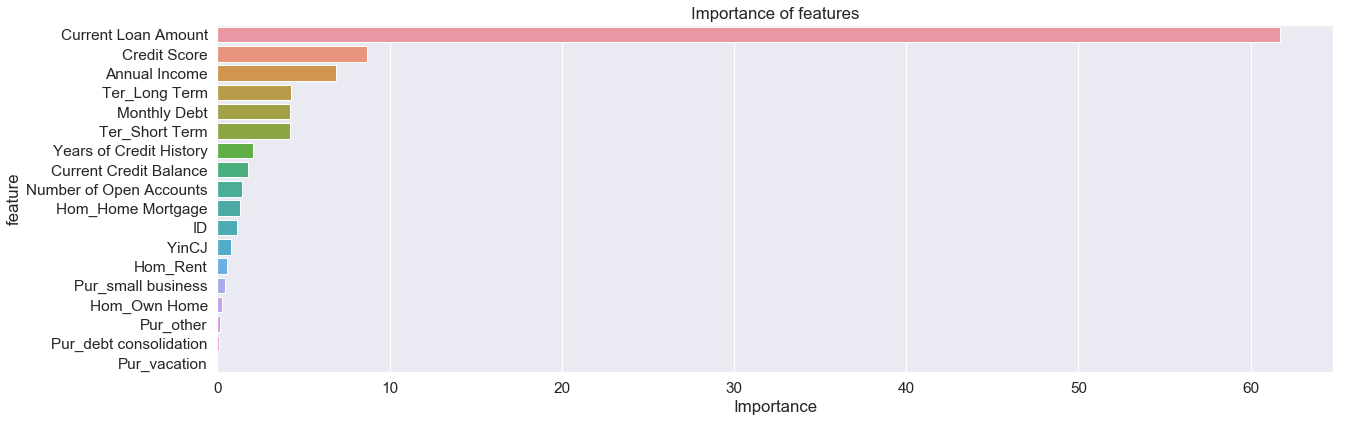

['Current Loan Amount', 'Credit Score', 'Annual Income', 'Ter_Long Term', 'Monthly Debt', 'Ter_Short Term', 'Years of Credit History', 'Current Credit Balance', 'Number of Open Accounts', 'Hom_Home Mortgage', 'ID', 'YinCJ', 'Hom_Rent', 'Pur_small business', 'Hom_Own Home']


In [408]:

important_features_top = show_feature_importances(X.columns, model.feature_importances_, get_top=15)
print(important_features_top)

**Калибровка модели**

In [409]:

result = []
for item in range(1,100):
    
    lg_pred = model.predict_proba(X_test)[:,1]
        
    f1 = round(f1_score(y_test, lg_pred > item/100), 3)
    ps = round(precision_score(y_test, lg_pred > item/100), 3) 
    rs = round(recall_score(y_test, lg_pred > item/100), 3)
    
    result.append((item, f1, ps, rs))
    
df_result = pd.DataFrame(result, columns = ['threshold','f1','precision','recall']) 

#print(df_result[df_result['f1']==df_result['f1'].max()])
df_result.iloc[:,:]

,threshold,f1,precision,recall
0,1,0.440,0.282,1.0
1,2,0.440,0.282,1.0
2,3,0.440,0.282,1.0
3,4,0.441,0.283,1.0
4,5,0.441,0.283,1.0
...,...,...,...,...
94,95,0.000,0.000,0.0
95,96,0.000,0.000,0.0
96,97,0.000,0.000,0.0
97,98,0.000,0.000,0.0


In [410]:
df_result.iloc[55:65,:]

,threshold,f1,precision,recall
55,56,0.490,0.327,0.970
56,57,0.491,0.329,0.968
57,58,0.493,0.331,0.967
58,59,0.497,0.334,0.964
59,60,0.498,0.336,0.959
60,61,0.500,0.339,0.954
61,62,0.501,0.340,0.946
62,63,0.502,0.343,0.938
63,64,0.504,0.345,0.932
64,65,0.505,0.347,0.921


In [411]:

X[BASE_FEATURE_NAMES] = scaler.transform(X[BASE_FEATURE_NAMES])
Xt=df_test_new.copy()
Xt[BASE_FEATURE_NAMES] = scaler.transform(Xt[BASE_FEATURE_NAMES])
model.fit(X,y)
df_test_new_out_solver=(model.predict_proba(Xt)[:,1]>0.61).astype(int)

In [412]:
ans=pd.DataFrame(data=df_test_new_out_solver, columns=[CREDIT_DEFAULT])

In [413]:
ans.to_csv('Atest_predictions.csv', index=False)